In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
from torchsummary import summary
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix

In [4]:
train_set = torchvision.datasets.FashionMNIST(
    "./data", download=True, transform=transforms.Compose([transforms.ToTensor()])
)
test_set = torchvision.datasets.FashionMNIST(
    "./data",
    download=True,
    train=False,
    transform=transforms.Compose([transforms.ToTensor()]),
)

In [5]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=100)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=100)

In [6]:
def output_label(label):
    output_mapping = {
        0: "T-shirt/Top",
        1: "Trouser",
        2: "Pullover",
        3: "Dress",
        4: "Coat",
        5: "Sandal",
        6: "Shirt",
        7: "Sneaker",
        8: "Bag",
        9: "Ankle Boot",
    }
    input = label.item() if type(label) == torch.Tensor else label
    return output_mapping[input]

In [7]:
a = next(iter(train_loader))
a[0].size()

torch.Size([100, 1, 28, 28])

In [8]:
len(train_set)

60000

9


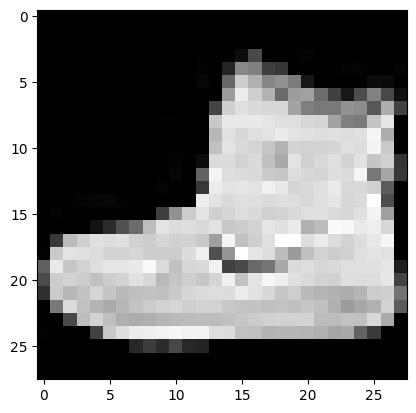

In [9]:
image, label = next(iter(train_set))
plt.imshow(image.squeeze(), cmap="gray")
print(label)

In [10]:
demo_loader = torch.utils.data.DataLoader(train_set, batch_size=10)

batch = next(iter(demo_loader))
images, labels = batch
print(type(images), type(labels))
print(images.shape, labels.shape)

<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([10, 1, 28, 28]) torch.Size([10])


In [11]:
demo_loader = torch.utils.data.DataLoader(train_set, batch_size=10)

batch = next(iter(demo_loader))
images, labels = batch
print(type(images), type(labels))
print(images.shape, labels.shape)

<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([10, 1, 28, 28]) torch.Size([10])


In [16]:
class AdjustedFashionCNN(nn.Module):
    def __init__(self, kernel_size=3):
        super(AdjustedFashionCNN, self).__init__()

        self.kernel_size = kernel_size
        input_size = 28  # Assuming the input images are 28x28
        output_channels1 = 32
        output_channels2 = 64

        # Compute output sizes after conv and pool operations
        conv1_out_size = input_size - self.kernel_size + 1
        pool1_out_size = (
            conv1_out_size // 2
        )  # Using kernel_size and stride=2 for pooling

        conv2_input_size = pool1_out_size
        conv2_out_size = conv2_input_size - self.kernel_size + 1
        pool2_out_size = conv2_out_size // 2

        fc_input_size = output_channels2 * pool2_out_size * pool2_out_size

        # Layer 2 to 5
        self.layer1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=output_channels1,
                kernel_size=self.kernel_size,
            ),  # Layer 2: Convolutional layer
            nn.BatchNorm2d(output_channels1),  # Layer 3: Batch normalization
            nn.ReLU(),  # Layer 4: ReLU activation
            nn.MaxPool2d(kernel_size=2, stride=2),  # Layer 5: Max Pooling
        )

        # Layer 6 to 9
        self.layer2 = nn.Sequential(
            nn.Conv2d(
                in_channels=output_channels1,
                out_channels=output_channels2,
                kernel_size=self.kernel_size,
            ),  # Layer 6: Convolutional layer
            nn.BatchNorm2d(output_channels2),  # Layer 7: Batch normalization
            nn.ReLU(),  # Layer 8: ReLU activation
            nn.MaxPool2d(kernel_size=2, stride=2),  # Layer 9: Max Pooling
        )

        # Layer 11
        self.fc1 = nn.Linear(in_features=fc_input_size, out_features=600)

        # Layer 10: Dropout
        self.drop = nn.Dropout2d(0.25)

        # Layer 12
        self.fc2 = nn.Linear(in_features=600, out_features=120)

        # Layer 13: Classification layer
        self.fc3 = nn.Linear(in_features=120, out_features=10)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)

        return out


# Create an instance of the adjusted model with a kernel size of 3 (for example) and print its architecture
adjusted_fashion_model = AdjustedFashionCNN(kernel_size=3)
adjusted_fashion_model

# Check if GPU is available and move the model to GPU if possible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
adjusted_fashion_model.to(device)

AdjustedFashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=1600, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)

C:\Users\ahmad\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\nn\functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch [1/5], Train Accuracy: 69.99%, Test Accuracy: 77.98%, Train Loss: 1.0480, Test Loss: 0.6417
Epoch [2/5], Train Accuracy: 80.27%, Test Accuracy: 81.67%, Train Loss: 0.5585, Test Loss: 0.5099
Epoch [3/5], Train Accuracy: 83.67%, Test Accuracy: 84.20%, Train Loss: 0.4669, Test Loss: 0.4497
Epoch [4/5], Train Accuracy: 85.52%, Test Accuracy: 85.35%, Train Loss: 0.4181, Test Loss: 0.4155
Epoch [5/5], Train Accuracy: 86.46%, Test Accuracy: 85.94%, Train Loss: 0.3879, Test Loss: 0.3941
Training and testing completed!


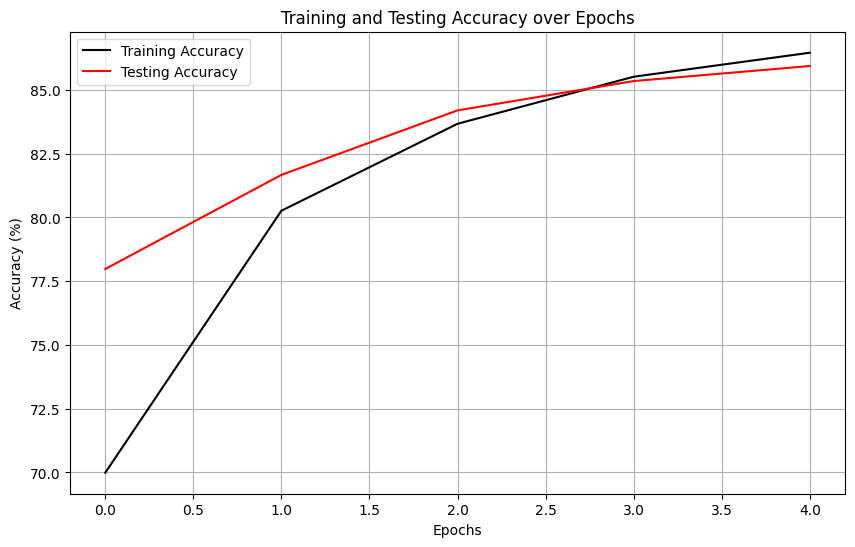

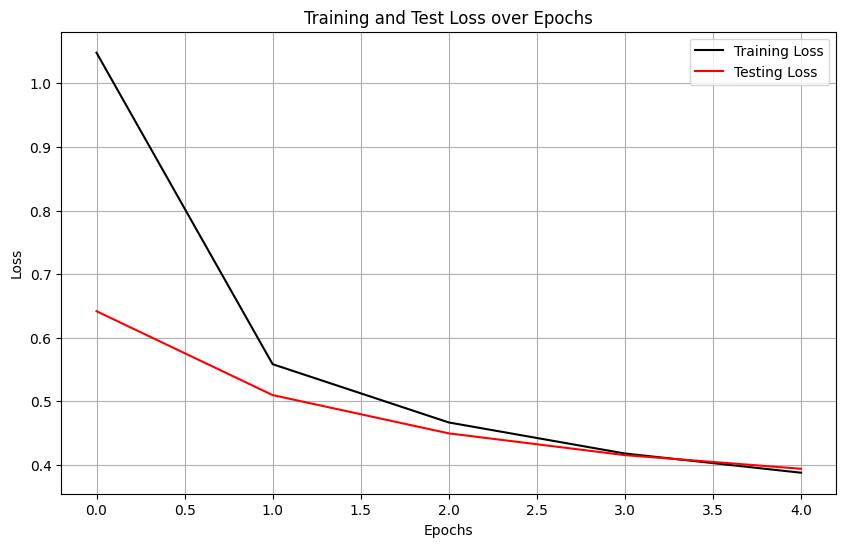

In [17]:
# Defining the train and test functions


def train(model, data_loader, criterion, optimizer):
    model.train()
    correct = 0
    total = 0
    total_loss = 0.0

    for images, labels in data_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    average_loss = total_loss / len(data_loader)
    return accuracy, average_loss


def test(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    total_loss = 0.0

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            loss = criterion(outputs, labels)
            total_loss += loss.item()

    accuracy = 100 * correct / total
    average_loss = total_loss / len(data_loader)
    return accuracy, average_loss


# Model, loss function, optimizer initialization
model = AdjustedFashionCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

# Training the model and capturing metrics
num_epochs = 5
train_accuracies, test_accuracies, train_losses, test_losses = [], [], [], []

for epoch in range(num_epochs):
    train_accuracy, train_loss = train(model, train_loader, criterion, optimizer)
    test_accuracy, test_loss = test(model, test_loader)

    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)
    train_losses.append(train_loss)
    test_losses.append(test_loss)

    print(
        f"Epoch [{epoch+1}/{num_epochs}], Train Accuracy: {train_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}"
    )

print("Training and testing completed!")

# Visualizing the results
plt.figure(figsize=(10, 6))
plt.plot(train_accuracies, "k", label="Training Accuracy")
plt.plot(test_accuracies, "r", label="Testing Accuracy")
plt.title("Training and Testing Accuracy over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend(loc="upper left")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(train_losses, "k", label="Training Loss")
plt.plot(test_losses, "r", label="Testing Loss")
plt.title("Training and Test Loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.grid(True)
plt.show()


Training with kernel size: 2

Epoch [1/5], Train Accuracy: 72.79%, Test Accuracy: 78.96%, Train Loss: 0.9322, Test Loss: 0.5922
Epoch [2/5], Train Accuracy: 81.71%, Test Accuracy: 82.93%, Train Loss: 0.5222, Test Loss: 0.4830
Epoch [3/5], Train Accuracy: 84.71%, Test Accuracy: 84.84%, Train Loss: 0.4427, Test Loss: 0.4312
Epoch [4/5], Train Accuracy: 86.18%, Test Accuracy: 85.78%, Train Loss: 0.3996, Test Loss: 0.4002
Epoch [5/5], Train Accuracy: 87.06%, Test Accuracy: 86.54%, Train Loss: 0.3714, Test Loss: 0.3787
Finished Training for kernel size: 2

Training with kernel size: 3

Epoch [1/5], Train Accuracy: 69.71%, Test Accuracy: 77.19%, Train Loss: 1.0329, Test Loss: 0.6460
Epoch [2/5], Train Accuracy: 79.84%, Test Accuracy: 81.42%, Train Loss: 0.5653, Test Loss: 0.5206
Epoch [3/5], Train Accuracy: 83.24%, Test Accuracy: 83.49%, Train Loss: 0.4787, Test Loss: 0.4639
Epoch [4/5], Train Accuracy: 84.89%, Test Accuracy: 84.67%, Train Loss: 0.4319, Test Loss: 0.4298
Epoch [5/5], Train 

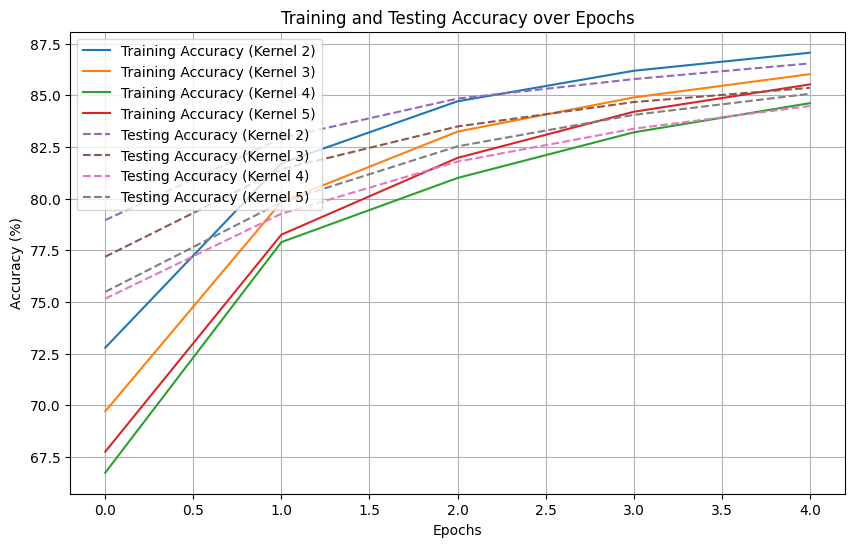

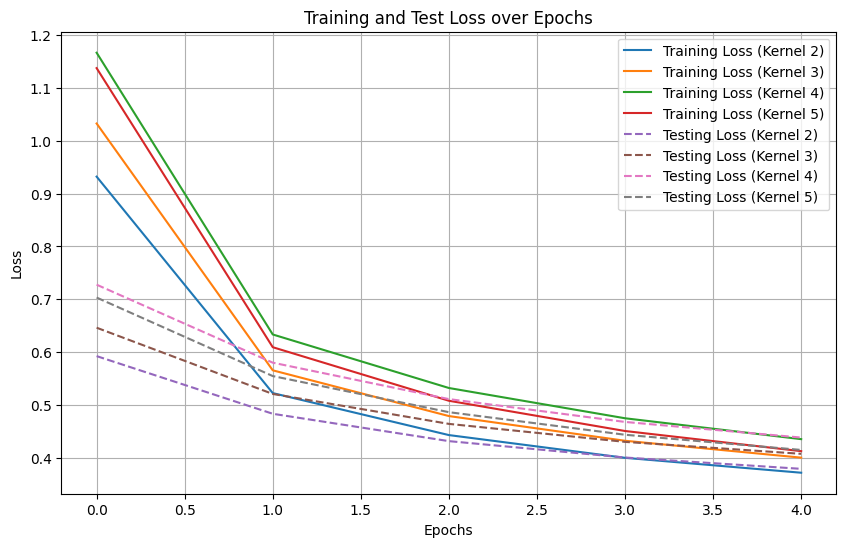

In [18]:
# List of kernel sizes to experiment with
kernelSizes = [2, 3, 4, 5]

# Initialize lists to store the overall results for each kernel size
all_train_accuracies = {}
all_test_accuracies = {}
all_train_losses = {}
all_test_losses = {}

for kernel in kernelSizes:
    print(f"\nTraining with kernel size: {kernel}\n")
    # Model, loss function, optimizer initialization for current kernel size
    model = AdjustedFashionCNN(kernel_size=kernel).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

    # Lists to store metrics for the current kernel size
    train_accuracies, test_accuracies, train_losses, test_losses = [], [], [], []

    for epoch in range(num_epochs):
        train_accuracy, train_loss = train(model, train_loader, criterion, optimizer)
        test_accuracy, test_loss = test(model, test_loader)

        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)
        train_losses.append(train_loss)
        test_losses.append(test_loss)

        print(
            f"Epoch [{epoch+1}/{num_epochs}], Train Accuracy: {train_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}"
        )

    # Store the results for the current kernel size
    all_train_accuracies[kernel] = train_accuracies
    all_test_accuracies[kernel] = test_accuracies
    all_train_losses[kernel] = train_losses
    all_test_losses[kernel] = test_losses

    print("Finished Training for kernel size:", kernel)

# Visualizing the results for all kernel sizes
plt.figure(figsize=(10, 6))
for kernel, acc in all_train_accuracies.items():
    plt.plot(acc, label=f"Training Accuracy (Kernel {kernel})")
for kernel, acc in all_test_accuracies.items():
    plt.plot(acc, "--", label=f"Testing Accuracy (Kernel {kernel})")

plt.title("Training and Testing Accuracy over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend(loc="upper left")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
for kernel, loss in all_train_losses.items():
    plt.plot(loss, label=f"Training Loss (Kernel {kernel})")
for kernel, loss in all_test_losses.items():
    plt.plot(loss, "--", label=f"Testing Loss (Kernel {kernel})")

plt.title("Training and Test Loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.grid(True)
plt.show()

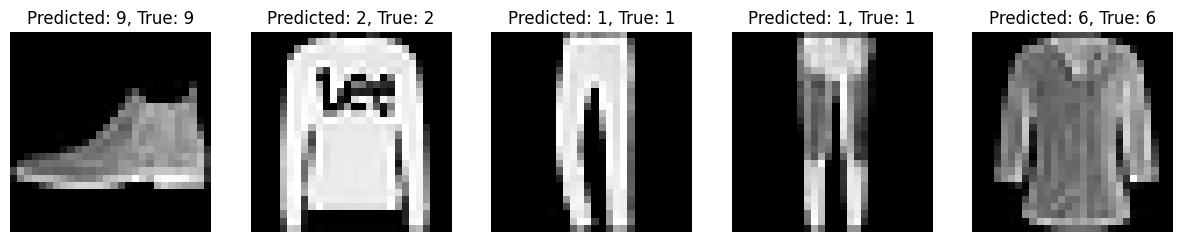

In [19]:
# Function to predict and plot
def predict_and_plot(model, data_loader, num_images=5):
    model.eval()  # Set the model to evaluation mode
    images_so_far = 0
    fig = plt.figure(figsize=(15, 7))

    with torch.no_grad():
        for i, (images, labels) in enumerate(data_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            for j in range(images.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 5, 5, images_so_far)
                ax.axis("off")
                ax.set_title(f"Predicted: {preds[j]}, True: {labels[j]}")
                img = images.cpu().data[j].numpy().transpose((1, 2, 0))
                plt.imshow(img.squeeze(), cmap="gray")

                if images_so_far == num_images:
                    return


# Predict and plot using the test data
predict_and_plot(model, test_loader)

In [ ]:
# Define hyperparameters to tune
learning_rates = [0.1, 0.01, 0.001]
batch_sizes = [32, 64, 128]
optimizers = [torch.optim.SGD, torch.optim.Adam]
dropout_rates = [0.2, 0.5]
kernel_sizes = [2, 3, 4, 5]

best_accuracy = 0.0
best_params = {}

# Grid search
for lr in learning_rates:
    for bs in batch_sizes:
        for opt in optimizers:
            for dr in dropout_rates:
                for ks in kernel_sizes:
                    train_loader = torch.utils.data.DataLoader(train_set, batch_size=bs)
                    test_loader = torch.utils.data.DataLoader(test_set, batch_size=bs)

                    model = AdjustedFashionCNN(kernel_size=ks).to(device)
                    criterion = nn.CrossEntropyLoss()
                    optimizer = opt(model.parameters(), lr=lr)

                    # Train and test the model with the current hyperparameters
                    for epoch in range(num_epochs):
                        train_accuracy, _ = train(
                            model, train_loader, criterion, optimizer
                        )
                        test_accuracy, _ = test(model, test_loader)

                    # Update best accuracy and parameters
                    if test_accuracy > best_accuracy:
                        best_accuracy = test_accuracy
                        best_params = {
                            "lr": lr,
                            "batch_size": bs,
                            "optimizer": opt,
                            "dropout_rate": dr,
                            "kernel_size": ks,
                        }

print("Best Test Accuracy:", best_accuracy)
print("Best Hyperparameters:", best_params)

In [20]:
import torch.nn as nn


class AdjustedFashionCNN(nn.Module):
    def __init__(
        self, kernel_size=3, num_filters1=32, num_filters2=64, dropout_rate=0.25
    ):
        super(AdjustedFashionCNN, self).__init__()

        self.kernel_size = kernel_size
        input_size = 28  # Assuming the input images are 28x28

        # Compute output sizes after conv and pool operations
        conv1_out_size = input_size - self.kernel_size + 1
        pool1_out_size = (
            conv1_out_size // 2
        )  # Using kernel_size=2 and stride=2 for pooling

        conv2_input_size = pool1_out_size
        conv2_out_size = conv2_input_size - self.kernel_size + 1
        pool2_out_size = conv2_out_size // 2

        fc_input_size = num_filters2 * pool2_out_size * pool2_out_size

        # Layer 2 to 5
        self.layer1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=num_filters1,
                kernel_size=self.kernel_size,
            ),  # Layer 2: Convolutional layer
            nn.BatchNorm2d(num_filters1),  # Layer 3: Batch normalization
            nn.ReLU(),  # Layer 4: ReLU activation
            nn.MaxPool2d(kernel_size=2, stride=2),  # Layer 5: Max Pooling
        )

        # Layer 6 to 9
        self.layer2 = nn.Sequential(
            nn.Conv2d(
                in_channels=num_filters1,
                out_channels=num_filters2,
                kernel_size=self.kernel_size,
            ),  # Layer 6: Convolutional layer
            nn.BatchNorm2d(num_filters2),  # Layer 7: Batch normalization
            nn.ReLU(),  # Layer 8: ReLU activation
            nn.MaxPool2d(kernel_size=2, stride=2),  # Layer 9: Max Pooling
        )

        # Layer 11
        self.fc1 = nn.Linear(in_features=fc_input_size, out_features=600)

        # Layer 10: Dropout
        self.drop = nn.Dropout2d(dropout_rate)

        # Layer 12
        self.fc2 = nn.Linear(in_features=600, out_features=120)

        # Layer 13: Classification layer
        self.fc3 = nn.Linear(in_features=120, out_features=10)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)

        return out


# For testing purposes:
# Create an instance of the adjusted model with a kernel size of 3 and filter numbers of 32 and 64 respectively.
# Print its architecture.
adjusted_fashion_model = AdjustedFashionCNN(
    kernel_size=3, num_filters1=32, num_filters2=64
)
print(adjusted_fashion_model)

AdjustedFashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=1600, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


In [ ]:
# Define hyperparameters to tune
learning_rates = [0.1, 0.01, 0.001]
batch_sizes = [32, 64, 128]
optimizers = [torch.optim.SGD, torch.optim.Adam]
dropout_rates = [0.2, 0.5]
kernel_sizes = [2, 3, 4, 5]
num_filters1 = [16, 32, 64]
num_filters2 = [32, 64, 128]

best_accuracy = 0.0
best_params = {}

# Counter to keep track of configurations
config_count = 1
total_configs = (
    len(learning_rates)
    * len(batch_sizes)
    * len(optimizers)
    * len(dropout_rates)
    * len(kernel_sizes)
    * len(num_filters1)
    * len(num_filters2)
)

# Grid search
for lr in learning_rates:
    for bs in batch_sizes:
        for opt in optimizers:
            for dr in dropout_rates:
                for ks in kernel_sizes:
                    for nf1 in num_filters1:
                        for nf2 in num_filters2:
                            print(f"Configuration {config_count}/{total_configs}:")
                            print(
                                f"LR: {lr}, BS: {bs}, Optimizer: {opt.__name__}, Dropout: {dr}, Kernel: {ks}, Filters1: {nf1}, Filters2: {nf2}"
                            )

                            train_loader = torch.utils.data.DataLoader(
                                train_set, batch_size=bs
                            )
                            test_loader = torch.utils.data.DataLoader(
                                test_set, batch_size=bs
                            )

                            model = AdjustedFashionCNN(
                                kernel_size=ks,
                                num_filters1=nf1,
                                num_filters2=nf2,
                                dropout_rate=dr,
                            ).to(device)
                            criterion = nn.CrossEntropyLoss()
                            optimizer = opt(model.parameters(), lr=lr)

                            # Train and test the model with the current hyperparameters
                            for epoch in range(num_epochs):
                                train_accuracy, _ = train(
                                    model, train_loader, criterion, optimizer
                                )
                                test_accuracy, _ = test(model, test_loader)

                            # Update best accuracy and parameters
                            if test_accuracy > best_accuracy:
                                best_accuracy = test_accuracy
                                best_params = {
                                    "lr": lr,
                                    "batch_size": bs,
                                    "optimizer": opt,
                                    "dropout_rate": dr,
                                    "kernel_size": ks,
                                    "num_filters1": nf1,
                                    "num_filters2": nf2,
                                }
                            print(
                                f"Test Accuracy for this configuration: {test_accuracy:.2f}%"
                            )
                            print(
                                "------------------------------------------------------"
                            )
                            config_count += 1

print("Best Test Accuracy:", best_accuracy)
print("Best Hyperparameters:", best_params)

In [22]:
# Define hyperparameters to tune
learning_rates = [0.1, 0.01, 0.001]
batch_sizes = [32, 64, 128]
optimizers = [torch.optim.SGD, torch.optim.Adam]
dropout_rates = [0.2, 0.5]
kernel_sizes = [2, 3, 4, 5]
num_epochs = 5

best_accuracy = 0.0
best_params = {}

results = {}  # Dictionary to store results

# Counter to keep track of configurations
config_count = 1
total_configs = (
    len(learning_rates)
    * len(batch_sizes)
    * len(optimizers)
    * len(dropout_rates)
    * len(kernel_sizes)
)
# Grid search
for lr in learning_rates:
    for bs in batch_sizes:
        for opt in optimizers:
            for dr in dropout_rates:
                for ks in kernel_sizes:
                    config_key = f"LR: {lr}, BS: {bs}, Optimizer: {opt.__name__}, Dropout: {dr}, Kernel: {ks}"
                    print(f"Configuration {config_count}/{total_configs}:")
                    print(config_key)

                    train_loader = torch.utils.data.DataLoader(train_set, batch_size=bs)
                    test_loader = torch.utils.data.DataLoader(test_set, batch_size=bs)

                    model = AdjustedFashionCNN(kernel_size=ks, dropout_rate=dr).to(
                        device
                    )
                    criterion = nn.CrossEntropyLoss()
                    optimizer = opt(model.parameters(), lr=lr)

                    # Variables to store cumulative loss across epochs
                    total_train_loss = 0.0
                    total_test_loss = 0.0

                    # Train and test the model with the current hyperparameters for the specified number of epochs
                    for epoch in range(num_epochs):
                        train_accuracy, train_loss = train(
                            model, train_loader, criterion, optimizer
                        )
                        total_train_loss += train_loss

                        # Skip further training and testing for this configuration if training accuracy is less than 80%
                        if train_accuracy < 80.0:
                            print(
                                "Train accuracy is less than 80%. Skipping this configuration."
                            )
                            break

                        test_accuracy, test_loss = test(model, test_loader)
                        total_test_loss += test_loss

                        # Printing per-epoch results
                        print(f"Epoch {epoch+1}/{num_epochs}:")
                        print(
                            f"Train Accuracy: {train_accuracy:.2f}% - Train Loss: {train_loss:.4f}"
                        )
                        print(
                            f"Test Accuracy: {test_accuracy:.2f}% - Test Loss: {test_loss:.4f}"
                        )
                        print("----------------------------------------")

                    avg_train_loss = total_train_loss / num_epochs
                    avg_test_loss = total_test_loss / num_epochs

                    # Store the results ONLY if train_accuracy >= 80%
                        if train_accuracy >= 80.0:
                            results[config_key] = {
                                "Train Accuracy": train_accuracy,
                                "Test Accuracy": test_accuracy,
                                "Average Train Loss": avg_train_loss,
                                "Average Test Loss": avg_test_loss,
                            }

                    # Update best accuracy and parameters
                    if test_accuracy > best_accuracy:
                        best_accuracy = test_accuracy
                        best_params = {
                            "lr": lr,
                            "batch_size": bs,
                            "optimizer": opt,
                            "dropout_rate": dr,
                            "kernel_size": ks,
                        }
                    print("------------------------------------------------------")
                    config_count += 1

print("Best Test Accuracy:", best_accuracy)
print("Best Hyperparameters:", best_params)

Configuration 1/144:
LR: 0.1, BS: 32, Optimizer: SGD, Dropout: 0.2, Kernel: 2
Epoch 1/5:
Train Accuracy: 82.48% - Train Loss: 0.4945
Test Accuracy: 82.82% - Test Loss: 0.4577
----------------------------------------
Epoch 2/5:
Train Accuracy: 88.59% - Train Loss: 0.3198
Test Accuracy: 88.66% - Test Loss: 0.3154
----------------------------------------
Epoch 3/5:
Train Accuracy: 89.86% - Train Loss: 0.2787
Test Accuracy: 89.30% - Test Loss: 0.3063
----------------------------------------
Epoch 4/5:
Train Accuracy: 90.64% - Train Loss: 0.2555
Test Accuracy: 89.96% - Test Loss: 0.2876
----------------------------------------
Epoch 5/5:
Train Accuracy: 91.31% - Train Loss: 0.2382
Test Accuracy: 89.95% - Test Loss: 0.2945
----------------------------------------
------------------------------------------------------
Configuration 2/144:
LR: 0.1, BS: 32, Optimizer: SGD, Dropout: 0.2, Kernel: 3
Epoch 1/5:
Train Accuracy: 83.07% - Train Loss: 0.4703
Test Accuracy: 85.36% - Test Loss: 0.4053
--

In [23]:
import pandas as pd

# Convert the results dictionary to a DataFrame
df_results = pd.DataFrame.from_dict(results, orient="index")

# Save the DataFrame to a CSV file
df_results.to_csv("./data/results.csv")

print("Results saved to 'results.csv'")

Results saved to 'results.csv'


In [ ]:
# run their parameters in the fashion and get the results
# run the diffrent parameters in the fashion data and get the best combinations .... Arend claimed low Kernal size will be better
# take the best hyperparamets and run it on the MRI data set and then comapre
# check if hypertuning on small dataset can be faster/better and it our claim would be correct and genralize it to larger dataset
# then check if we get better results than the MRI paper